In [1]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from fastprogress.fastprogress import master_bar, progress_bar
%matplotlib inline

from variables import maze_list, Actions

import environment
from environment import maze_game

from tiered_algorithm import words_to_actions, actions_to_words, state_to_actions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
environment.set_device(device)

print(f'GPU available: {torch.cuda.is_available()}')

GPU available: True


In [2]:
bow = [
    'move',
    'up',
    'left',
    'right',
    'down',
    'one',
    'two',
    'three',
    'blocks',
    '',
    'and',
    'then',
    '1',
    '2',
    '3',
    '4',
    '5',
    'four',
    'five',
    'block',
    'north',
    'south',
    'east',
    'west',
    'go',
    'walk',
    'proceed',
    'step',
    'steps',
    'space',
    'spaces',
]

tensor([[[1]],

        [[4]],

        [[4]],

        [[4]]], device='cuda:0')

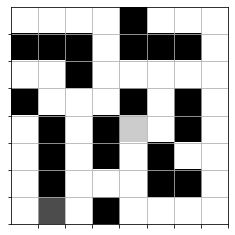

In [3]:
game = maze_game([maze_list[0]])
game.reset()
game.set_target(np.array([4,4]))
game.show()
game.state_to_channels(game.state).shape
# game.valid_actions()
game.best_seq()

In [4]:
def play_game(model, maze, start=None, target=None, max_episodes=100, show_game=False, epsilon=0):
    game = maze_game([maze])
    game.reset()
    
    if start is not None:
        game.set_position(start)
    if target is not None:
        game.set_target(target)
        
    while game.is_complete():
        game.reset()
        if start is not None:
            game.set_position(start)
        if target is not None:
            game.set_target(target)
        
    episode = 0
    envstate = game.get_state()
    while episode < max_episodes:
        episode += 1
        valid_actions = game.valid_actions()
        
        if np.random.rand() < epsilon or model==None:
            actions = [random.choice(valid_actions)]
        else:
            action = sender_net(game.get_state()[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
#             sentence = [bow[i.item()] for i in action]

            enc = torch.eye(len(bow))[[i.item() for i in action]].view(len(action),len(bow)).to(device)
            actions = policy_net(enc[None]).max(2)[1].view(1, max_actions, 1, 1)[0]
            actions = [Actions(i.item()) for i in actions]
        
        envstate, reward, done, win = game.step(actions)
        
        if done:
            break
    
    if show_game: game.show()
    
    return win, episode

(True, 75)

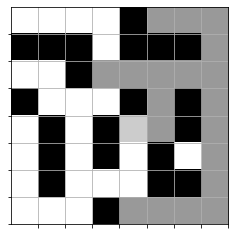

In [5]:
play_game(None, maze_list[0], show_game=True, target=np.array([4,4]))

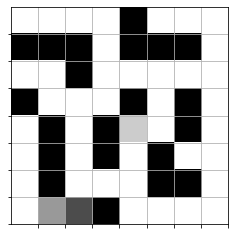

In [6]:
game.step(state_to_actions(game.state, limit_n=4))
game.show()

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [8]:
sequence_length = 4
max_actions = 4
n_inputs = len(bow)

class DQN_SENDER(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN_SENDER, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1)
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)
        self.relu2 = nn.ReLU(inplace=False)
        
        convw = 4
        convh = 4
        linear_conv_size = convw * convh * 64
        
        self.gru = nn.GRU(linear_conv_size, linear_conv_size, 2)
        
        self.head = nn.Linear(linear_conv_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        # Flatten
        x = x.view(x.shape[0], -1)
        
        x, hn = self.gru(x.repeat(sequence_length,1,1))
        
        return self.head(x.transpose(0,1))

class DQN_RECEIVER(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN_RECEIVER, self).__init__()
        
        convw = 4
        convh = 4
        linear_conv_size = convw * convh * 64
        
        self.gru = nn.GRU(n_inputs, linear_conv_size, 2)
        self.gru2 = nn.GRU(linear_conv_size, linear_conv_size, 2)
        
        self.head = nn.Linear(linear_conv_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        # Flatten
        x, hn = self.gru(x.transpose(0,1))
        
        x, hn = self.gru2(hn[1].repeat(max_actions,1,1))
        
        return self.head(x.transpose(0,1))

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.4
EPS_END = 0.01
EPS_DECAY = 5000
TARGET_UPDATE = 10


screen_height, screen_width = maze_list[0].shape

n_actions = 5

policy_net = DQN_RECEIVER(screen_height, screen_width, n_actions).to(device)
target_net = DQN_RECEIVER(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=5e-5)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, valid_actions=[]):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state[None]).max(2)[1].view(1, max_actions, 1, 1)[0]
    else:
        if len(valid_actions) > 0:
            return torch.tensor([[random.choice(valid_actions).value]], device=device, dtype=torch.long).unsqueeze(1).repeat(max_actions,1,1)
        return torch.tensor([[random.randrange(n_actions, sequence_length)]], device=device, dtype=torch.long)


episode_durations = []

map_num = 0
import pickle
with open(f'models/sender.pkl', 'rb') as f:
    sender_net = pickle.load(f)


In [10]:
def optimize_model():
#     return
    optimizer.zero_grad()
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None], dim=0)
    
    state_batch = torch.stack(batch.state, dim=0)
    action_batch = torch.stack(batch.action, dim=0)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_actions = policy_net(state_batch)
    
    state_actions = torch.stack([state_actions[:,i].gather(1, action_batch[:,i]) for i in range(sequence_length)], dim=1)
    
    state_action_values = state_actions.sum(dim=1)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(2)[0].sum(dim=1).detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    loss.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss
optimize_model()

In [11]:
def encode_bow(seq):
    return torch.eye(len(bow))[[bow.index(s) for s in seq]].view(len(seq),len(bow)).to(device)

In [ ]:
# with torch.autograd.detect_anomaly():
# save_file='2020_10_08_receiver_3'
# save_skip=2500
num_episodes = 5000
mb = progress_bar(range(num_episodes))
p_skip = 100

# env = maze_game([maze_list[map_num]])
env = maze_game(maze_list)

w_hist = []
r_hist = []

# for i_episode in mb:
for i_episode in mb:
    # Initialize the environment and state
    env.reset()
    env.set_target(np.array([4,4]))
    while env.is_complete():
        env.reset()
        env.set_target(np.array([4,4]))

    a = sender_net(env.get_state()[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
    sentence = [bow[i.item()] for i in a]
    sentence += ['']*(sequence_length - len(sentence))
    
    last_state = encode_bow(sentence)
    state = last_state
    loss = []
    for t in count():
        
        # Select and perform an action
        valid_actions = env.valid_actions()
        
        action = select_action(state, valid_actions=valid_actions)
        

        actions = [Actions(i.item()) for i in action]
    
        a_reward = 0
        
        r = max_actions
        for a,b in enumerate(actions):
            if b != Actions.NONE:
                r = a
                
        actions = actions[:r+1]
        
        action = action.view(max_actions,1)
        
        _, reward, done, win = env.step(actions)
        reward += a_reward
        
        reward = torch.tensor([reward], device=device)
        r_hist += [reward.item()]
        # Observe new state
        if not done:
            a = sender_net(env.get_state()[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
            sentence = [bow[i.item()] for i in a]
            sentence += ['']*(sequence_length - len(sentence))
        
            next_state = encode_bow(sentence)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss += [optimize_model()]

        if done:
            w_hist.append(win)
            episode_durations.append(t + 1)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
#     print(f"episode: {i_episode:3d}/{num_episodes-1} | steps: {t+1:3d} | wins: {sum(w_hist):3d} | Epsilon: {eps_threshold:.3f}")
#     if (i_episode+1)%save_skip==0:
#         with open(f'models/{save_file}_policy.pkl', 'wb') as f:
#             pickle.dump(policy_net, f)
#         with open(f'models/{save_file}_target.pkl', 'wb') as f:
#             pickle.dump(target_net, f)

    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
        
        
    if (i_episode+1)%p_skip == 0:
        print(f"Episode: {i_episode:4d}/{num_episodes-1} | Rounds: {env.rounds:3d} | Steps: {env.steps:3d} | Wins: {sum(w_hist):4d} | Epsilon: {eps_threshold:.3f} | Avg Episode Reward: {f'{np.mean(r_hist[-(t+1):]):.4f}':>7s} | Avg Reward: {f'{np.mean(r_hist[-200:]):.4f}':>7s} | Total Winrate: {f'{sum(w_hist)/(i_episode+1)*100:>3.1f}':>5s}% | Recent Winrate: {f'{sum(w_hist[-p_skip:])/(p_skip)*100:>3.1f}':>5s}%")

In [4]:
map_num = 2
env = maze_game([maze_list[map_num]])
env.reset()
env.set_target(np.array([4,4]))
env.set_position(np.array([0,1]))

a = sender_net(env.get_state()[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
sentence = [bow[i.item()] for i in a]
enc = encode_bow(sentence)

action = policy_net(enc[None]).max(2)[1].view(1, max_actions, 1, 1)[0]

actions = [Actions(i.item()) for i in action]
print(f"Sentence: '{' '.join(sentence)}'")

if len(actions) == 0:
    actions = [Actions.NONE]
env.step(actions)
env.show()
print(actions)

NameError: name 'sender_net' is not defined

In [48]:
mb = progress_bar(range(2000))
# m = [maze_list[map_num]]
m = maze_list
w_hist = [[] for i in range(len(m))]
s_hist = [[] for i in range(len(m))]
for i in mb:
    maze_num = np.random.randint(0, len(m))
    win,steps = play_game(policy_net, m[maze_num], epsilon=0.01, target=np.array([4,4]))
    w_hist[maze_num] = np.append(w_hist[maze_num], win)
    s_hist[maze_num] = np.append(s_hist[maze_num], steps)

print(f"Total Win Rate: {np.mean(np.concatenate(np.array(w_hist)))*100:.2f}%, Avg Steps: {np.mean(np.concatenate(np.array(s_hist)))}")
for i,j in enumerate(w_hist):
    print(f"Maze {i}: {f'{np.mean(j)*100:.2f}':>6s}%, {np.mean(s_hist[i]):.2f} steps")

Total Win Rate: 97.75%, Avg Steps: 3.6475
Maze 0:  87.61%, 6.99 steps
Maze 1: 100.00%, 3.52 steps
Maze 2: 100.00%, 2.48 steps
Maze 3: 100.00%, 4.10 steps
Maze 4:  98.74%, 2.76 steps
Maze 5: 100.00%, 2.01 steps


<ipython-input-48-51c51ad03891>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(f"Total Win Rate: {np.mean(np.concatenate(np.array(w_hist)))*100:.2f}%, Avg Steps: {np.mean(np.concatenate(np.array(s_hist)))}")


In [125]:
import pickle
with open('models/combined_receiver_policy.pkl', 'wb') as f:
    pickle.dump(policy_net, f)
with open('models/combined_receiver_target.pkl', 'wb') as f:
    pickle.dump(target_net, f)

In [19]:
import pickle
with open('models/combined_receiver_policy.pkl', 'rb') as f:
    policy_net = pickle.load(f)
with open('models/combined_receiver_target.pkl', 'rb') as f:
    target_net = pickle.load(f)